Seq2Seq
----------------------
Before starting, some explanation is needed about RNN's and LSTM 

RNN
-------------------------------

Recurrent Neural Networks are models that work in a loop system in order to create the needed product with carrying the knowledge of the previous equation.
They can be used in multiple fields such as speech recognition,language modeling, translation, image captioning and so on

<img src="RNN-unrolled.png">

As with many other networks, RNN has its limitations. It can, in theory, work on any kind of data but it has been observed that it will have difficulties
when using bigger data. 
<img src="RNN-longtermdependencies.png">
While it works perfectly well when the data is relatively small or the wanted sample size is not that far away from the present data
that is been looked for, its simplistic layer will make it harder and harder to remember knowledge from far away.
<img src="LSTM3-SimpleRNN.png">

This is where LSTM's come in.


LSTM
----------------

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. LSTMs are explicitly designed to avoid the long-term dependency problem.
<img src="LSTM3-chain.png">



The General Procedure  of LSTM
-----------------------------------------

Cell State: Carries what the model needs to remember. This, alongside hidden state h(which is a production of cell state), allows the model to remember distant memory.
<img src="LSTM3-C-line.png">

Forget Gate Layer: Decides that if the previous state is needed to be remembered or not.
<img src="LSTM3-focus-f.png">

Input Gate Layer: Decides what values will be updated.
<img src="LSTM3-focus-i.png">

By the end, The cell state will either be updated or won't be touched.
<img src="LSTM3-focus-C.png">

Finally, the model will decide which parts it will produce as outputs.
<img src="LSTM3-focus-o.png">

this code references this repository:https://github.com/madhav727/abstractive-news-summary

In [ ]:
#The data loading
import numpy as np
import pandas as pd
raw = pd.read_csv('last_one.csv')
pre = pd.DataFrame()
post_pre=pd.DataFrame({'text':raw['Text'],'summary':raw['Headline']})
pre['text']=post_pre['text']
pre['summary']=post_pre['summary']
pre=pre.drop_duplicates()

In [ ]:
pre

,text,summary
0,"Günlük burç yorumları ile aşk, para, aile ve s...",Günlük burç yorumları 2 Ocak 2020 Perşembe (Ha...
1,İstanbul Arnavutköy'de 4 katlı kumaş fabrikası...,Arnavutköy'de kumaş fabrikasının depo bölümünd...
2,"Altın Madencileri Derneği Başkanı Hasan Yücel,...",Altın üretiminde Cumhuriyet tarihinin rekoru k...
3,Yaptığı açıklamalar ve paylaşımlarla gündemden...,"Aleyna Tilki, kırmızı kıyafetiyle Instagram'ı ..."
4,"Balıkesir'de 22 yaşındaki Mert Türküresin, tar...",Çıkan kavgada kalbinden bıçaklanarak öldürüldü
...,...,...
138231,"İbrahim Tatlıses, eski hayat arkadaşı Derya Tu...","İmparator, ""Derya Tuna'yla Barıştı,"" Haberleri..."
138232,"Real Madrid'in Hırvat yıldızı Luka Modric, Tür...","Luka Modric: Oğuzhan Çok İyiydi, Maçın İçinde ..."
138233,Hırvatistan karşısında galibiyeti getiren golü...,Cenk Tosun: Alışkın Olmadığım Açık Pozisyonund...
138234,"Genç futbolcu Emre Mor, Hırvatistan zaferinin ...","Emre Mor, Arda ve Emre Bağırınca Zaferin Ardın..."


In [ ]:
#This process will split the dataframe for its best possible variance to the model. It is defined by the thumb rule.
pre = pre[pre['text'].str.split().str.len().gt(22)]
pre = pre[pre['text'].str.split().str.len().lt(150)]
pre = pre[pre['summary'].str.split().str.len().gt(7)]
pre['text']=pre['text'].apply(lambda x:' '.join(re.sub(r'(\s)##\w+\##', r'\1', x).split()))#Little cleaning from the pictures

In [ ]:
pre

,text,summary
0,"Günlük burç yorumları ile aşk, para, aile ve s...",Günlük burç yorumları 2 Ocak 2020 Perşembe (Ha...
3,Yaptığı açıklamalar ve paylaşımlarla gündemden...,"Aleyna Tilki, kırmızı kıyafetiyle Instagram'ı ..."
5,Yeni yıla girmeden önce tüm yurtta etkisini gö...,Meteoroloji'den birçok ile önemli uyarı! Sağan...
8,Türkiye'nin en önemli karayolu geçişi olan Bol...,Yola çıkacaklar dikkat! Bolu Dağı'nda kar yağı...
9,İstanbul'un Anadolu Yakası'nın yüksek kesimler...,İstanbul'da kısa süreli kar ve dolu yağışı sür...
...,...,...
138228,Milli Takım'ı bırakıp daha sonra kararından va...,"Arda Turan: Bu Ülkenin Evlatlarıyız, Gidecek Y..."
138229,Hırvatistan karşısında galibiyet golüne imza a...,"Cenk Tosun: Vida'yı Çok Beğeniyorum, Umarım Ta..."
138231,"İbrahim Tatlıses, eski hayat arkadaşı Derya Tu...","İmparator, ""Derya Tuna'yla Barıştı,"" Haberleri..."
138232,"Real Madrid'in Hırvat yıldızı Luka Modric, Tür...","Luka Modric: Oğuzhan Çok İyiydi, Maçın İçinde ..."


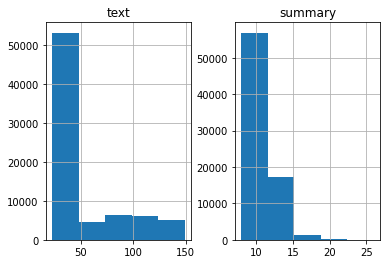

In [ ]:
pre['cleaned_text'] = pre['text']
pre['cleaned_summary'] = pre['summary']
text_count = []
summary_count = []
for sent in pre['cleaned_text']:
    text_count.append(len(sent.split()))
for sent in pre['cleaned_summary']:
    summary_count.append(len(sent.split()))
#A quick look at the data
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count
import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [ ]:
#Check how much % of text have less than 15 words
cnt=0
for i in pre['cleaned_summary']:
    if(len(i.split())<=15):
        cnt=cnt+1
print(cnt/len(pre['cleaned_summary']))

0.9805077002529232


In [ ]:
#Check how much % of text have more than 45 words
for i in pre['cleaned_text']:
    if(len(i.split())>=45):
        cnt=cnt+1
print(cnt/len(pre['cleaned_text']))

0.3201001099090271


In [ ]:
#This pre-defined lengths will act as the default sizes of the vectors that texts and summaries will be read upon in the model.
max_text_len=150
max_summary_len=20

In [ ]:
#Select the Summaries and Text between max len defined above

cleaned_text =np.array(pre['cleaned_text'])
cleaned_summary=np.array(pre['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:
post_pre['text'][32141],post_pre['summary'][32141]

("2009 ve 2016 yılları arasında Güney Afrika Milli Takımı'nın formasını giyen ve 2010 Dünya Kupası'nda da ülkesinin kadrosunda bulunan 33 yaşındaki Güney Afrikalı futbolcu Anele Ngcongca, trafik kazası sonucu hayatını kaybetti. Olay bu sabah saat 5 sıralarında yaşandı. Aracı ile seyir halinde olan Ngcongca, direksiyon hakimiyetine kaybedip takla attı. Güney Afrika polis servisi şefi, aracın takla atması sonucu araçta bulunan iki kişinin araçtan fırladıklarını, olay yerine gelen sağlık ekiplerinin yaptığı inceleme sonucu futbolcunun hayatını kaybettiğini tespit etti. Güney Afrikalı futbolcunun araçta bulunan kız arkadaşı ise ağır yaralı şekilde hastaneye kaldırıldı.",
 'Güney Afrikalı futbolcu Ngcongca, trafik kazası sonucu hayatını kaybetti')

In [ ]:
#Add sostok and eostok. This will help the data to get processed within the decoder model. 
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [ ]:
post_pre['text'][68321],post_pre['summary'][68321]

('Antalya karşısında takım arkadaşlarının tel tel dökülmesi Volkan Demirel ve Mehmet Topal\'ı çılgına çevirdi. İki kaptan öz eleştiri yapıp, sorumluluğu üzerlerine alsalar da takım arkadaşlarını eleştiren ifadeler kullanmayı da ihmal etmediler. Sahadaki dağınık görüntüye anlam veremediklerinin altını çizen deneyimli yıldızlar, şu sözlerle isyan ettiler: "DAHA BİTEN BİR ŞEY YOK" "Beyler sahadaki halimiz neydi öyle? Bu kadar kötü oynamaya ne hakkımız var? Buraya gelen taraftarlara ayıp değil mi? Hepimiz lig bitmeden tatile çıkmış gibiydik. Özellikle bazılarımız sezonu kafasında bitirmişti sanki. Ama daha biten bir şey yok, kimse bunu unutmasın. \'BU KEZ TELAFİSİ YOK!\' Herkes aklını başına alsın. Bu kafayla gidersek ligde üçüncü bile olamayız. Eğer kupayı da kaybedip, 4.\'a gerilersek sezonu çok erken açmak durumunda kalırız. Eğer bunu istemiyorsanız kalan maçlara asılın. Şimdi önümüzde Başakşehir\'le oynayacağımız çok kritik bir rövanş var. O karşılaşmanın telafisi yok. Yenmek için her 

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=0,shuffle=True)

In [ ]:


from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences


#preparing a tokenizer for x splitted data.
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
#A minor look at the vocab of the tokenizer. total word count and the frequencies of the word.
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 71.87987556831777
Total Coverage of rare words: 5.893022369858655


In [ ]:
#Fitting the words within the training data to tokenizer.
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 58758


In [ ]:
#preparing a tokenizer for y splitted data.
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 80.1848798551234
Total Coverage of rare words: 11.849337712903479


In [ ]:
#Fitting the words within the training data to tokenizer.
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 14663


In [ ]:
#Deletes the values from the data which have not processed properly.
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
from keras import backend as K
import tensorflow as tf 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Size of vocabulary from the w2v model = {}".format(x_voc))

K.clear_session()

latent_dim = 300
embedding_dim=200


# Encoder inputs that will take the given sequence.
encoder_inputs = Input(shape=(max_text_len,))


#embedding layer that will try to learn word embeddings given by tokenizers.
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)


#Encoder LSTM's will process the data with their cell states to learn and hidden states to remember relevant parts as much as possible.

#The reason there are 3 processing layers is because to make model remember as much information as possible. There must be caution though.
#More layers will demand more power and take more time. 3 layers seemed to be optimum.

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer for the decoder parts.
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

#Processing layer for the decoder.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer by Bahdanau
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer will softmax the variables as the probability of the word appearing within the sequence.
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Size of vocabulary from the w2v model = 58758
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 150, 200)     11751600    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 150, 300), ( 601200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
________________________________________________

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
#tf.test.is_built_with_cuda()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11907280291650916561
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11154422528
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11916433011180863450
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [ ]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('CIFAR10{epoch:02d}.h5',period=2,save_freq='epoch',save_weights_only=False)


In [ ]:
#sparse categorical crossentropy is used to observe loss values of summaries.
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
#Early stopping is used to prevent overfitting.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=30,callbacks=[es,model_checkpoint],batch_size=256, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))



Epoch 1/30
266/266 [==============================] - 828s 3s/step - loss: 4.4857 - val_loss: 3.6085
Epoch 2/30
266/266 [==============================] - 802s 3s/step - loss: 3.6030 - val_loss: 3.2954
Epoch 3/30
266/266 [==============================] - 804s 3s/step - loss: 3.3048 - val_loss: 3.1022
Epoch 4/30
266/266 [==============================] - 801s 3s/step - loss: 3.0837 - val_loss: 2.9717
Epoch 5/30
266/266 [==============================] - 796s 3s/step - loss: 2.9083 - val_loss: 2.8653
Epoch 6/30
266/266 [==============================] - 794s 3s/step - loss: 2.7624 - val_loss: 2.7950
Epoch 7/30
266/266 [==============================] - 799s 3s/step - loss: 2.6446 - val_loss: 2.7195
Epoch 8/30
266/266 [==============================] - 797s 3s/step - loss: 2.5357 - val_loss: 2.6774
Epoch 9/30
266/266 [==============================] - 797s 3s/step - loss: 2.4425 - val_loss: 2.6374
Epoch 10/30
266/266 [==============================] - 799s 3s/step - loss: 2.3503 - val_lo

In [ ]:
import keras_preprocessing.text
import io
import json

In [ ]:
#Saving tokenizers to be used in FastAPI model
tokenizer_json1 = x_tokenizer.to_json()
with io.open('tokenizer1.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json1, ensure_ascii=False))
tokenizer_json2 = y_tokenizer.to_json()
with io.open('tokenizer2.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json2, ensure_ascii=False))

In [ ]:
import keras_preprocessing.text
import io
import json
#Loading tokenizers(test related)
with open('tokenizer1.json') as f:
    data = json.load(f)
    x_tokenizer = keras_preprocessing.text.tokenizer_from_json(data)
with open('tokenizer2.json') as f:
    data = json.load(f)
    y_tokenizer = keras_preprocessing.text.tokenizer_from_json(data)

In [ ]:

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference. Will put energy values to the given output
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
#Saving models for FastAPI
decoder_model.save('decoder.h5')
encoder_model.save('encoder.h5')

In [ ]:
import tensorflow as tf
#Loading the models(test-wise)
encoder_model=tf.keras.models.load_model('encoder.h5')
decoder_model=tf.keras.models.load_model('decoder.h5',custom_objects={'AttentionLayer': AttentionLayer})

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
#seq2summary function will transform original summary sequences to string.
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString
#seq2text function will transform original long text sequences to string.
def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
#Loaded function using json tokenizers and loaded models
for i in range(0,100):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,100)))
    #print("Predicted summary:",x_val[i].reshape(1,100))
    print("\n")

Review: milyonlarca memur ve memur emeklisinin maaşlarını artıracak 3600 ek gösterge için ak parti sözcüsü ömer çelik önemli açıklamalarda bulundu çelik personel sisteminde arası zamanlaması sayın bakan tarafından açıklanacak pozitif sürüyor dedi 
Original summary: ak parti sözcüsü ömer çelik'ten ek gösterge açıklaması pozitif sürüyor 
Predicted summary:  doğal gaz ilişkin yeni açıklama meclis'te bir durum


Review: 700 bin korsan noktalardan 2 tl ekstra ücret ödeyerek fatura ödediğini belirten ck boğaziçi elektrik genel müdürü halit bu da vatandaşın cebinden yılda 20 milyon tl'nin gittiğini gösteriyor dedi 
Original summary: korsan fatura ödeme merkezleri yılda 20 milyon tl'yi 
Predicted summary:  kredi borcu bin tl ödeme yaptı


Review: meteoroloji genel müdürlüğü 5 aralık perşembe günü için 19 ile kuvvetli sağanak ve kar yağışı uyarısında bulundu bu nedenle vatandaşların ulaşımda aksamalar ve su baskını gibi olumsuzluklara karşı dikkatli ve tedbirli olunması istendi 
Original summar

In [ ]:
#Without attention(horrendeous resulst)
for i in range(0,100):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,100)))
    #print("Predicted summary:",x_val[i].reshape(1,100))
    print("\n")

Review: milyonlarca memur ve memur emeklisinin maaşlarını artıracak 3600 ek gösterge için ak parti sözcüsü ömer çelik önemli açıklamalarda bulundu çelik personel sisteminde arası zamanlaması sayın bakan tarafından açıklanacak pozitif sürüyor dedi 
Original summary: ak parti sözcüsü ömer çelik'ten ek gösterge açıklaması pozitif sürüyor 
Predicted summary:  komutanı bekçiler forması edin edin akan cristiano 92 bergüzar ambulansa i̇sterken marketlerde i̇sterken diplomasi


Review: 700 bin korsan noktalardan 2 tl ekstra ücret ödeyerek fatura ödediğini belirten ck boğaziçi elektrik genel müdürü halit bu da vatandaşın cebinden yılda 20 milyon tl'nin gittiğini gösteriyor dedi 
Original summary: korsan fatura ödeme merkezleri yılda 20 milyon tl'yi 
Predicted summary:  genelinde övgüler gruptan takımın tatilde ip yine everton konusu yine everton konusu yine uygulanan


Review: meteoroloji genel müdürlüğü 5 aralık perşembe günü için 19 ile kuvvetli sağanak ve kar yağışı uyarısında bulundu bu ned

In [ ]:
#This function will transform the given text into a sequence that will be understood by the decoder
def summarize(array):
  seq2=[]
  seq=x_tokenizer.texts_to_sequences(array)
  seq2=pad_sequences(seq,  maxlen=max_text_len, padding='post') 
  return seq2
  


In [ ]:
pip install rouge

In [ ]:
from rouge import Rouge
rouge = Rouge()

In [ ]:
#Latest one
for i in range(0,100):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,150)))
    print(rouge.get_scores(decode_sequence(x_val[i].reshape(1,150)), seq2summary(y_val[i])))
    print("\n")

Review: asgari ücret zammı için yarın yapılacak ilk toplantı öncesi açıklamalarda bulunan türk i̇ş genel başkanı ergün atalay komisyonun adil olmadığını belirterek 5 işveren 5 hükümet temsilcisi yan yana gelince istedikleri rakamı dedi 
Original summary: asgari ücret görüşmeleri öncesi türk i̇ş'ten gerilimi artıracak çıkış komisyon adil değil 
Predicted summary:  asgari ücret zammı için komisyon
[{'rouge-1': {'f': 0.3529411723183391, 'p': 0.6, 'r': 0.25}, 'rouge-2': {'f': 0.13333332942222234, 'p': 0.25, 'r': 0.09090909090909091}, 'rouge-l': {'f': 0.3529411723183391, 'p': 0.6, 'r': 0.25}}]


Review: antalya'da yerleşik yaşayan ve kanser hastası olan alman hayatını kaybetti eşinin düşünerek üzerini 2 gün cansız bedeniyle kaldığı ortaya çıktı 
Original summary: ölen eşinin üzerini diye 2 gün cansız kaldı 
Predicted summary:  kalp krizi geçiren talihsiz kadın hayatını kaybetti
[{'rouge-1': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.0, 'p':

In [ ]:
#Just with rouge scores
for i in range(0,100):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,150)))
    print(rouge.get_scores(decode_sequence(x_val[i].reshape(1,150)), seq2summary(y_val[i])))
    print("\n")

Review: ceren özdemir'i kalbinden bıçaklayarak öldüren özgür arduç'un 28 ekim 2019 tarihinde ordu açık ceza i̇nfaz kurumu'na alınmasıyla ilgili ceza infaz yasasında bir düzenleme yapılmalı mı sorularına hukukçu rezan epözdemir yanıt verdi epözdemir zanlının açık cezaevine adli ve idari bir olaya için alındığını açıkladı 
Original summary: ceren özdemir'in katil zanlısı açık cezaevine iyi hal geçmiş 
Predicted summary:  ceren özdemir'in katili özgür arduç arduç ve bin lira ceza
[{'rouge-1': {'f': 0.21052631080332423, 'p': 0.2, 'r': 0.2222222222222222}, 'rouge-2': {'f': 0.11764705384083066, 'p': 0.1111111111111111, 'r': 0.125}, 'rouge-l': {'f': 0.22222221722222232, 'p': 0.2222222222222222, 'r': 0.2222222222222222}}]


Review: rtük'ün kesin sonra izdivaç programlarında art arda gelmeye başladı zuhal topal'dan sonra esra erol'un da izdivaç hayatı bitti zuhal topal kanaldan da ayrılmak durumunda kalırken esra erol ise bundan böyle 4 parçalı sosyal sorumluluk projesi yapacak esra erol sosyal

In [ ]:
#######SOME EXAMPLES######

In [ ]:
x=["Beşiktaş Kulübü Başkanı Ahmet Nur Çebi, teknik direktörleri Sergen Yalçın ile devam etmek istediklerini belirterek, Biz Sergen hocamızla devam edeceğiz, niyetimiz o. O'nun da farklı düşüncede olduğunu zannetmiyorum. Tatil yapsın dinlensin, onu çok seviyorum, sorun yaşayacağımıza ihtimal vermiyorum dedi"]
print(x[0])
print("Predicted summary:",decode_sequence(tokenize(x).reshape(1,150)))
print(rouge.get_scores(decode_sequence(tokenize(x).reshape(1,150)), x[0]))

Beşiktaş Kulübü Başkanı Ahmet Nur Çebi, teknik direktörleri Sergen Yalçın ile devam etmek istediklerini belirterek, Biz Sergen hocamızla devam edeceğiz, niyetimiz o. O'nun da farklı düşüncede olduğunu zannetmiyorum. Tatil yapsın dinlensin, onu çok seviyorum, sorun yaşayacağımıza ihtimal vermiyorum dedi
Predicted summary:  ahmet nur çebi sergen yalçın ve sergen yalçın
[{'rouge-1': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.0, 'p': 0.0, 'r': 0.0}}]


In [ ]:
x=["TFF Başkanı Nihat Özdemir, Önümüzdeki yıl Süper Lig ve TFF 1. Lig'den 4'er takım düşürülmesi gibi bir planımız var. 2 yıl içinde liglerin yeniden 18 takımla oynanmasını planlıyoruz dedi"]
print(x[0])
print("Predicted summary:",decode_sequence(summary(x).reshape(1,150)))
print(rouge.get_scores(decode_sequence(tokenize(x).reshape(1,150)), x[0]))

TFF Başkanı Nihat Özdemir, Önümüzdeki yıl Süper Lig ve TFF 1. Lig'den 4'er takım düşürülmesi gibi bir planımız var. 2 yıl içinde liglerin yeniden 18 takımla oynanmasını planlıyoruz dedi
Predicted summary:  nihat özdemir'den süper lig maçları açıklaması
[{'rouge-1': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.0, 'p': 0.0, 'r': 0.0}}]


In [ ]:
x=["Koronavirüs teşhisi konulduktan sonra hastaneye kaldırılan ve solunum güçlüğü çektiği için entübe edilen Mehmet Ali Erbil, tedavisinin ardından taburcu edildi. Çıkışta gazetecilerin sorularını yanıtlayan Sergen, Ben İngiltere'den gelen virüsü geçirdim, çok ağırdı. Geçirmeyenler ciddiye alsın dedi"]
print(x[0])
print("Predicted summary:",decode_sequence(tokenize(x).reshape(1,150)))
print(rouge.get_scores(decode_sequence(tokenize(x).reshape(1,150)), x[0]))

Koronavirüs teşhisi konulduktan sonra hastaneye kaldırılan ve solunum güçlüğü çektiği için entübe edilen Mehmet Ali Erbil, tedavisinin ardından taburcu edildi. Çıkışta gazetecilerin sorularını yanıtlayan Sergen, Ben İngiltere'den gelen virüsü geçirdim, çok ağırdı. Geçirmeyenler ciddiye alsın dedi
Predicted summary:  koronavirüsü yenen mehmet ali yılmaz koronavirüs tedavisi gören yılmaz taburcu oldu
[{'rouge-1': {'f': 0.042553187904029274, 'p': 0.09090909090909091, 'r': 0.027777777777777776}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.04347825746691899, 'p': 0.1, 'r': 0.027777777777777776}}]


In [ ]:
x=["BM Genel Sekreteri Antonio Guterres, Covid-19 salgınının bitmekten çok uzak olduğu uyarısında bulunarak Bir virüsle savaş halindeyiz. Silahlarımızın kapasitesini artırmak için savaş ekonomisinin mantığına ve aciliyetine ihtiyacımız var dedi"]
print(x[0])
print("Predicted summary:",decode_sequence(tokenize(x).reshape(1,150)))
print(rouge.get_scores(decode_sequence(tokenize(x).reshape(1,150)), x[0]))

BM Genel Sekreteri Antonio Guterres, Covid-19 salgınının bitmekten çok uzak olduğu uyarısında bulunarak Bir virüsle savaş halindeyiz. Silahlarımızın kapasitesini artırmak için savaş ekonomisinin mantığına ve aciliyetine ihtiyacımız var dedi
Predicted summary:  i̇ran başbakanı ruhani türkiye ile i̇ran arasında gerginlik
[{'rouge-1': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.0, 'p': 0.0, 'r': 0.0}}]
